# Explore here

It's recommended to use this notebook for exploration purposes.

In [11]:
import requests
import time

url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"

# Envía una solicitud HTTP GET
response = requests.get(url)

# Introduce una pausa de 10 segundos
time.sleep(10)

# Si la información está prohibida, nos conectamos de manera anónima
if response.status_code == 403:
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    time.sleep(10)

# Verifica nuevamente si la segunda solicitud fue exitosa
if response.status_code == 200:
    html_data = response.text

print(html_data)





<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
		<link rel="canonical" href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" />
		<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>
		<link rel="icon" type="image/x-icon" href="/assets/images/icons/FAVICON/macrotrends-favicon.ico">
		<meta name="description" content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement from which all costs and expenses are subtra

 ###  Paso 3 Transformamos los datos HTML

In [13]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(html_data,"html.parser")
soup


<!DOCTYPE html>

<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" rel="canonical"/>
<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>
<link href="/assets/images/icons/FAVICON/macrotrends-favicon.ico" rel="icon" type="image/x-icon"/>
<meta content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement from which all costs and expenses are subtracted to arrive at net income.    
				
				&

In [15]:
#Encuentra las tablas

tables = soup.find_all("table")
tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <tr>
 <td style="text-align:center">2015</td>
 <td style="text-align:center">$4,046</td>
 </tr>
 <t

In [17]:
#De la solucion, aqui tenemos dudas de estructura fundamentales.

import pandas as pd

for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

# Create a DataFrame
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)


## Paso 4  Procesa el DataFrame

A continuación, limpia las filas para obtener los valores limpios eliminando $ y las comas. Elimina también aquellas que estén vacías o no tengan información.



In [18]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue.head()

,Date,Revenue
0,2023-06-30,24927
1,2023-03-31,23329
2,2022-12-31,24318
3,2022-09-30,21454
4,2022-06-30,16934


### Paso 5: Almacena los datos en sqlite


In [20]:
import sqlite3

connection = sqlite3.connect("Tesla.db")
connection

In [23]:

cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")

OperationalError: table revenue already exists

In [24]:
tesla_tuples = list(tesla_revenue.to_records(index = False))
tesla_tuples[:5]

[('2023-06-30', '24927'),
 ('2023-03-31', '23329'),
 ('2022-12-31', '24318'),
 ('2022-09-30', '21454'),
 ('2022-06-30', '16934')]

In [25]:
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
connection.commit()

In [26]:
# Ser evisa la data en la base de datos
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('2013-09-30', '431')
('2013-06-30', '405')
('2013-03-31', '562')
('2012-12-31', '306')
('2012-09-30

### Visialuzación de la Data

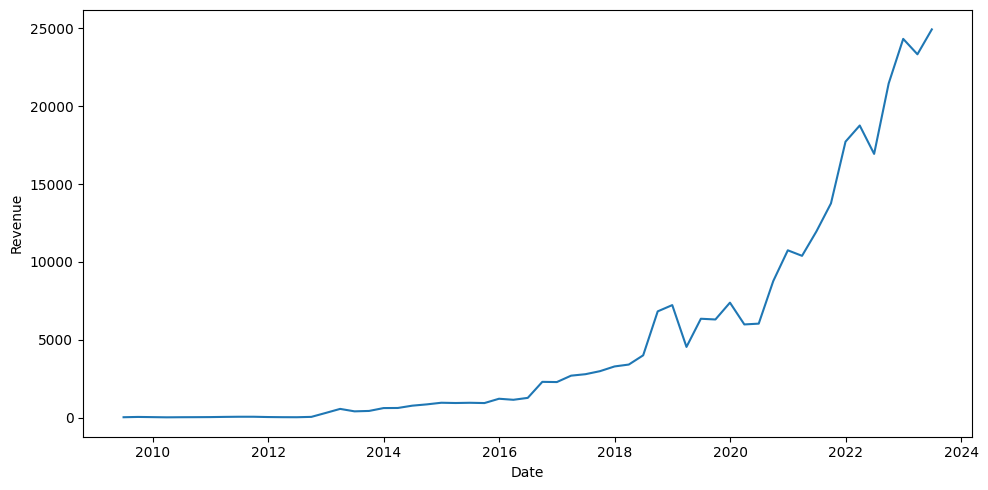

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### cCrecimientod de Beneficio

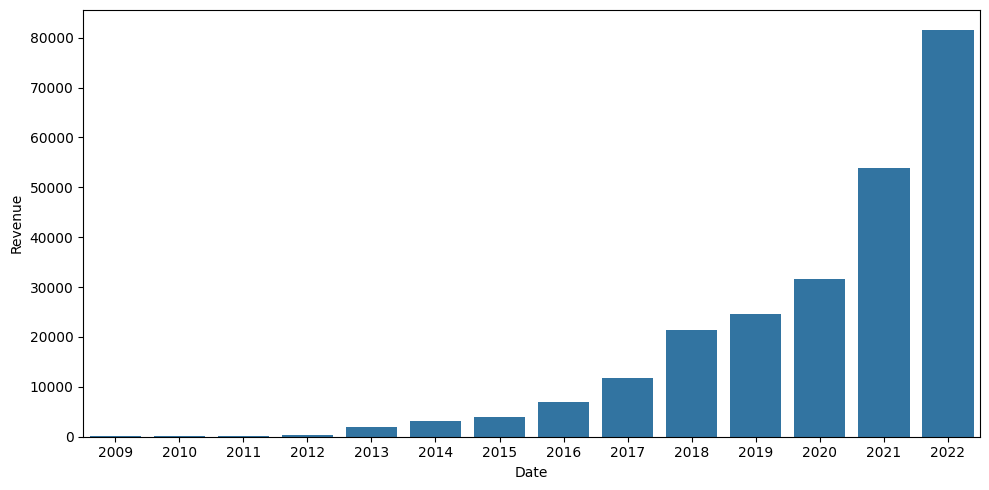

In [28]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year).sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

## Crecimiento Trimestral 

/tmp/ipykernel_528/420428727.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tesla_revenue_monthly, x="Date", y="Revenue", palette=palette)


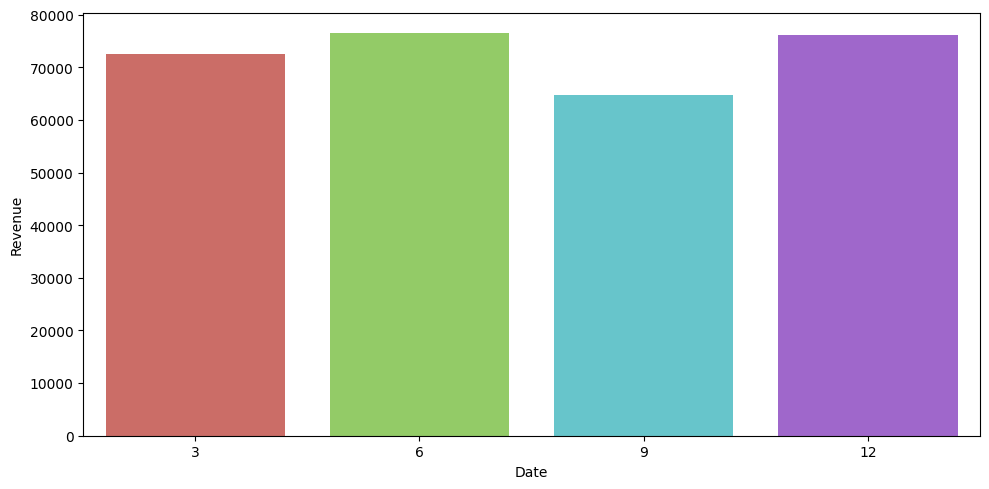

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una paleta de colores de Seaborn
palette = sns.color_palette("hls", len(tesla_revenue_monthly))

# Crear la figura y los ejes
fig, axis = plt.subplots(figsize=(10, 5))

# Crear el gráfico de barras
sns.barplot(data=tesla_revenue_monthly, x="Date", y="Revenue", palette=palette)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()
